<a href="https://colab.research.google.com/github/Aaditya-Prasad/PetTalk/blob/main/PetTalkOD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#OBJECT DETECTION
#I: One image
#O: One outline drawn over the input image + species of pet
#Notes: Trying to use one of the effecientnet models perhaps that my phone can run, but not needed

In [ ]:
#Semantic Classification
#I: Species of pet
#O: list of adjectives that describe pet
#Notes: could just be an API call

In [8]:
pip install google-cloud-vision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [43]:
from google.cloud import vision
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import time
import copy
import os
import cv2 as cv

In [17]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/pettalk-376101-8808a250a30c.json"

In [89]:
def detect_labels(path):
    import io
    import os
    # Imports the Google Cloud client library
    from google.cloud import vision
    # Instantiates a client
    client = vision.ImageAnnotatorClient()
    # The name of the image file to annotate
    file_name = os.path.abspath(path)
    # Loads the image into memory
    with io.open(file_name, 'rb') as image_file:
        content = image_file.read()
    image = vision.Image(content=content)
    # Performs label detection on the image file
    response = client.label_detection(image=image)
    labels = response.label_annotations
    print('Labels:')
    for label in labels:
        print(label.description)

    return labels

In [35]:
def localize_objects(path):
    """Localize objects in the local image.

    Args:
    path: The path to the local file.
    """
    from google.cloud import vision
    client = vision.ImageAnnotatorClient()

    with open(path, 'rb') as image_file:
        content = image_file.read()
    image = vision.Image(content=content)

    objects = client.object_localization(
        image=image).localized_object_annotations

    print('Number of objects found: {}'.format(len(objects)))
    for object_ in objects:
        print('\n{} (confidence: {})'.format(object_.name, object_.score))
        print('Normalized bounding polygon vertices: ')
        for vertex in object_.bounding_poly.normalized_vertices:
            print(' - ({}, {})'.format(vertex.x, vertex.y))

    return objects

In [97]:
duke = detect_labels("/duke.jpg")

Labels:
Dog
Comfort
Carnivore
Dog breed
Fawn
Companion dog
Couch
Snout
Toy dog
Paw


In [99]:
label_to_array(duke)

['Dog',
 'Comfort',
 'Carnivore',
 'Dog breed',
 'Fawn',
 'Companion dog',
 'Couch',
 'Snout',
 'Toy dog',
 'Paw']

In [98]:
def label_to_array(labels):
  return [t.description for t in labels]

Labels:
Dog
Plant
Carnivore
Yellow
Grass
Companion dog
Dog breed
Working animal
Flower
Terrier


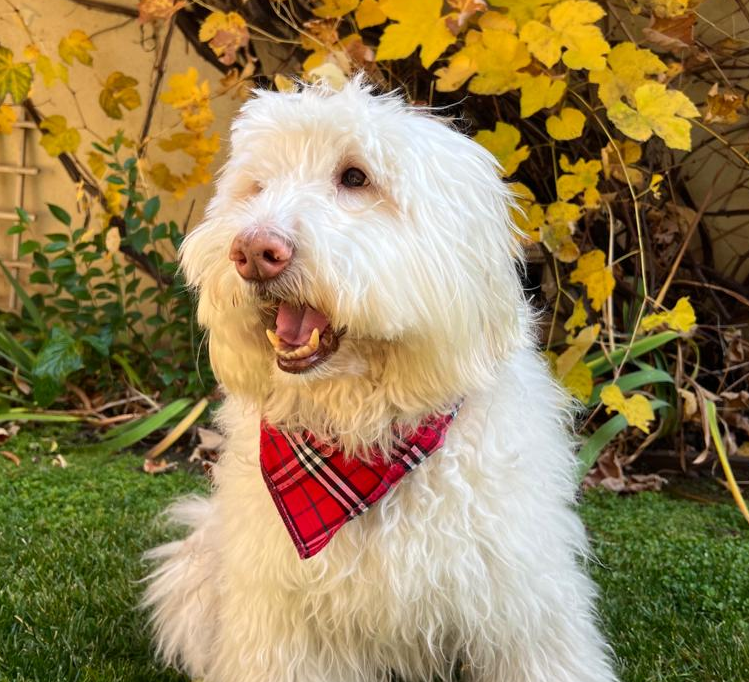

['Dog',
 'Plant',
 'Carnivore',
 'Yellow',
 'Grass',
 'Companion dog',
 'Dog breed',
 'Working animal',
 'Flower',
 'Terrier']

In [105]:
toby = detect_labels('/toby.jpeg')
toby_label = label_to_array(toby)
cutout('/toby.jpeg')
toby_label

In [33]:
client = vision.ImageAnnotatorClient()

In [90]:
german = detect_labels('/german.jpeg')

Labels:
Dog
Plant
Flowerpot
Houseplant
Dog breed
Carnivore
German shepherd dog
Shelf
Picture frame
Fawn


In [95]:
german_labels = [g.description for g in german]

In [96]:
german_labels

['Dog',
 'Plant',
 'Flowerpot',
 'Houseplant',
 'Dog breed',
 'Carnivore',
 'German shepherd dog',
 'Shelf',
 'Picture frame',
 'Fawn']

In [93]:
german[0]

mid: "/m/0bt9lr"
description: "Dog"
score: 0.9594585299491882
topicality: 0.9594585299491882

In [40]:
objs = localize_objects('/german.jpeg')

Number of objects found: 3

Dog (confidence: 0.7747383713722229)
Normalized bounding polygon vertices: 
 - (0.21678270399570465, 0.005255299154669046)
 - (0.8825307488441467, 0.005255299154669046)
 - (0.8825307488441467, 0.9809183478355408)
 - (0.21678270399570465, 0.9809183478355408)

Houseplant (confidence: 0.6979075074195862)
Normalized bounding polygon vertices: 
 - (0.002106947125867009, 0.010861647315323353)
 - (0.22491104900836945, 0.010861647315323353)
 - (0.22491104900836945, 0.7850618362426758)
 - (0.002106947125867009, 0.7850618362426758)

Flowerpot (confidence: 0.6187201142311096)
Normalized bounding polygon vertices: 
 - (0.0380367673933506, 0.5624166131019592)
 - (0.1707162708044052, 0.5624166131019592)
 - (0.1707162708044052, 0.7694197297096252)
 - (0.0380367673933506, 0.7694197297096252)


In [74]:
ver = objs[0].bounding_poly.normalized_vertices[:]
ver[0].x

0.21678270399570465

In [100]:
def cutout(path):
  img = cv.imread(path)
  x, y, _ = img.shape
  x_b = (int(ver[0].x * x), int(ver[1].x * x))
  y_b = (int(ver[1].y * y), int(ver[2].y * y))
  cutout = img[x_b[0]:x_b[1], y_b[0]:y_b[1]]
  cv2_imshow(cutout)

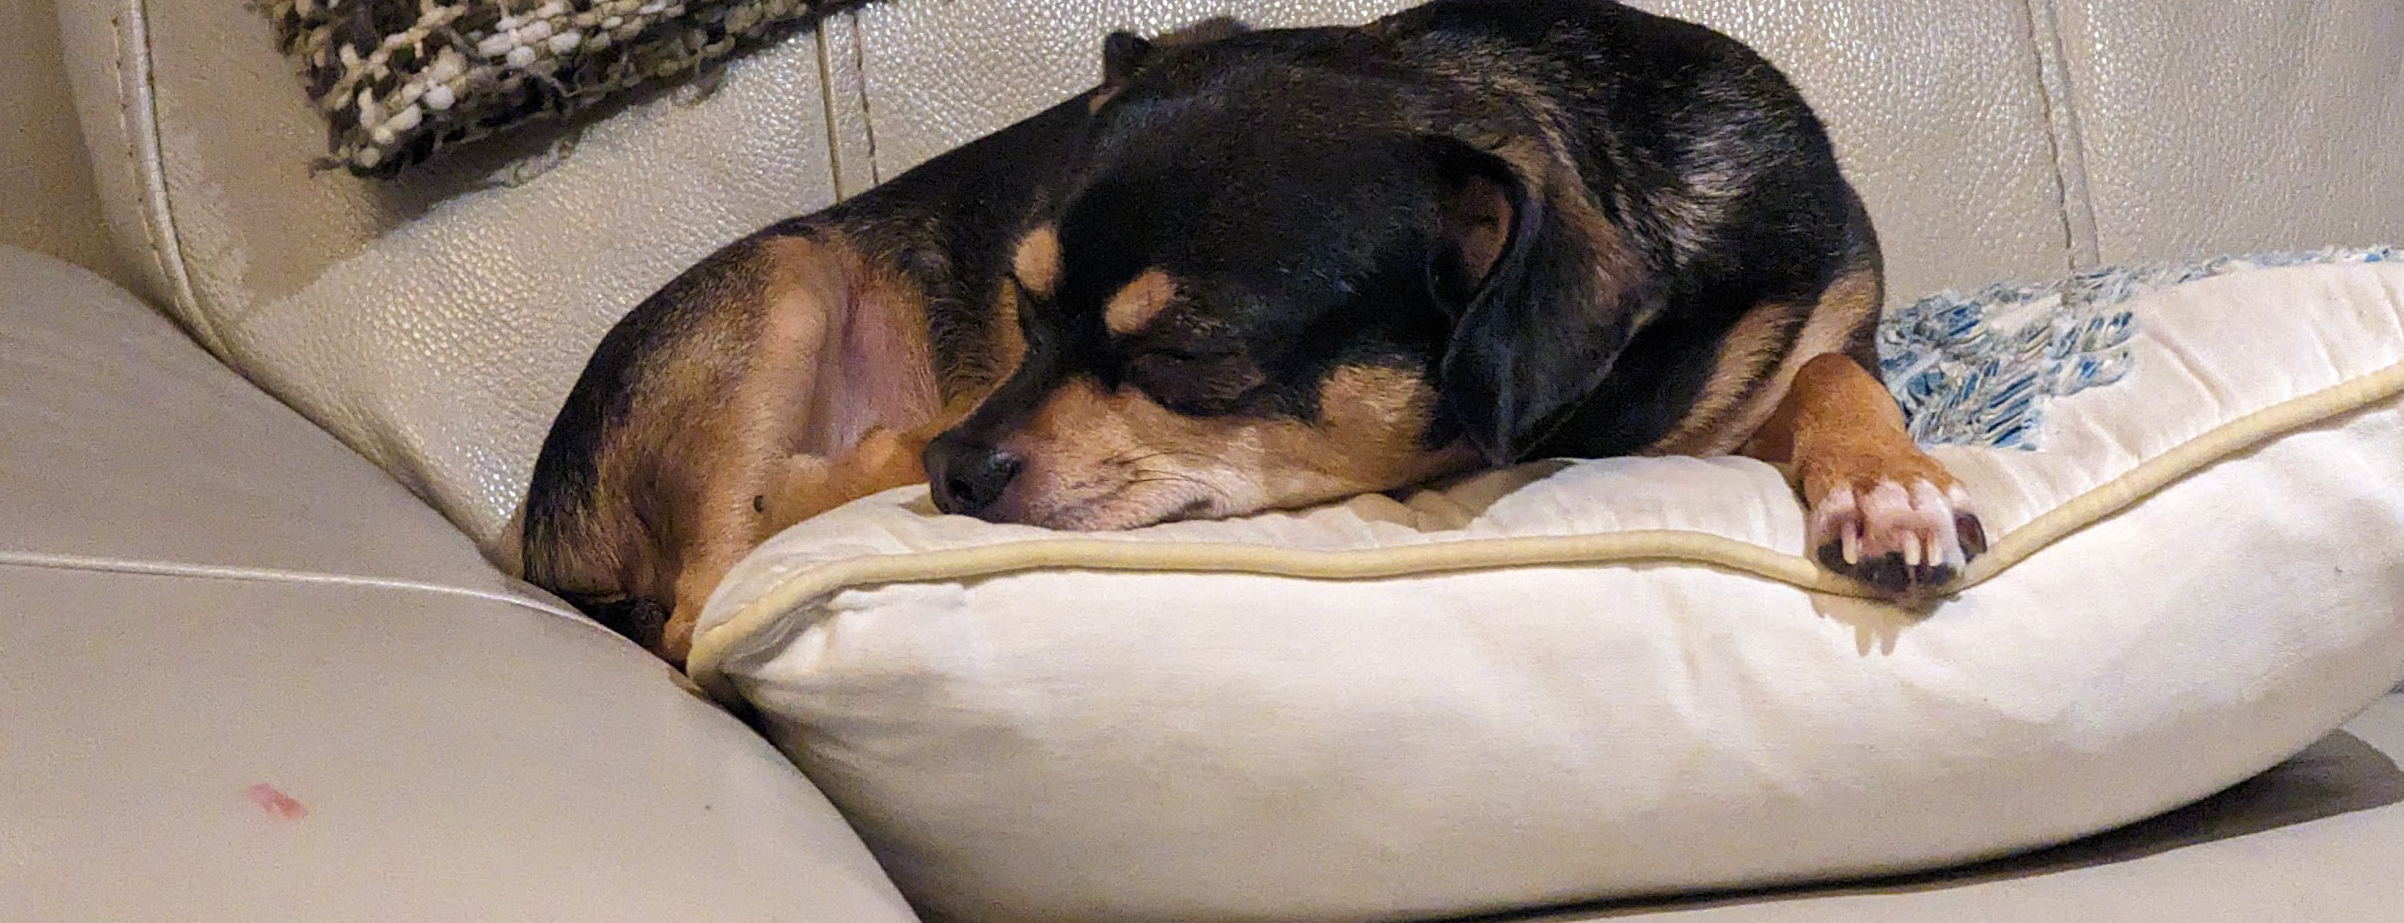

In [101]:
cutout('/duke.jpg')

In [58]:
img = cv.imread('/german.jpeg')

In [81]:
x, y, _ = img.shape
x_b = (int(ver[0].x * x), int(ver[1].x * x))
y_b = (int(ver[1].y * y), int(ver[2].y * y))
cutout = img[x_b[0]:x_b[1], y_b[0]:y_b[1]]

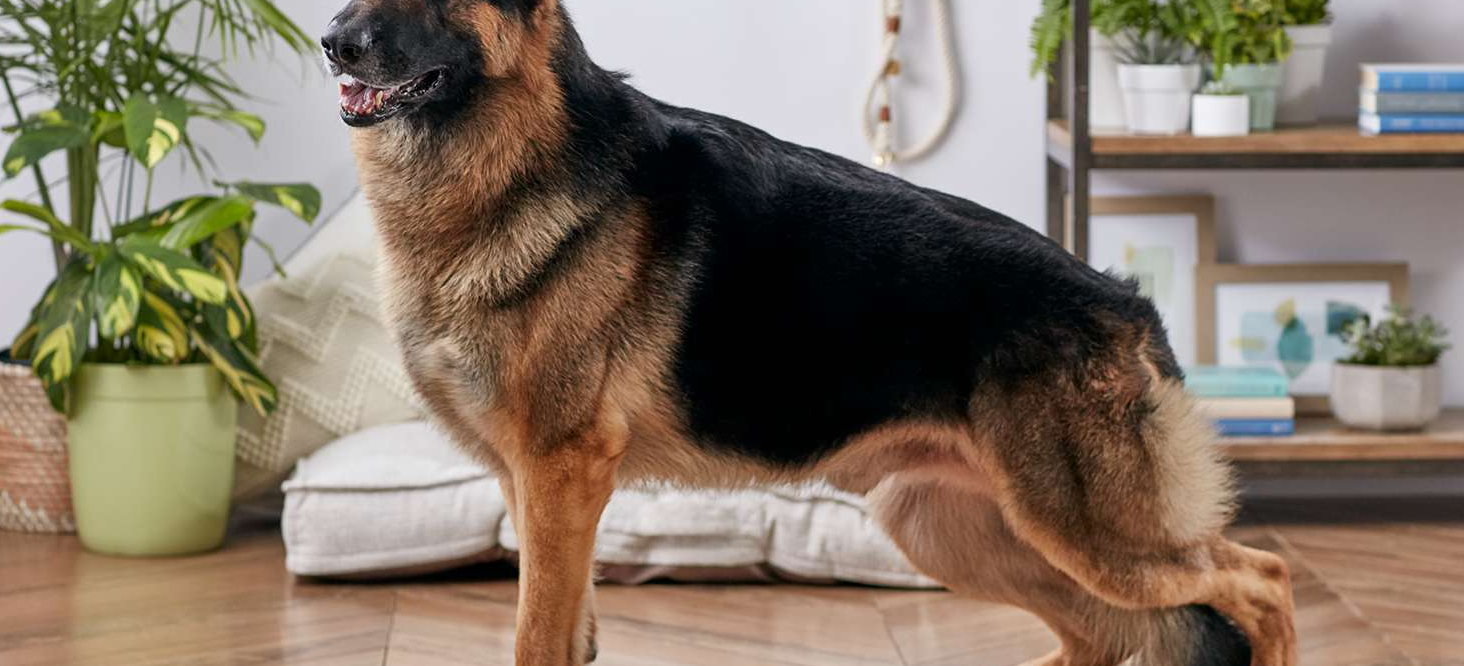

In [84]:
from google.colab.patches import cv2_imshow
cv2_imshow(cutout)

In [85]:
detect_labels("/german_cut.png")

Labels:
Dog
Plant
Dog breed
Carnivore
Fawn
Companion dog
Terrestrial animal
Tail
Working animal
Sporting Group
